In [23]:
!pip install rdkit
!pip install torch_geometric

In [24]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from timeit import default_timer as timer
import matplotlib.pyplot as plt
# RDkit
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from rdkit.Chem.Crippen import MolLogP
from rdkit.Chem.rdMolDescriptors import GetMACCSKeysFingerprint
from rdkit.Chem import AllChem
# Pytorch
import torch
from torch.nn import Linear, MSELoss
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing, GCNConv, aggr, pool
from torch_geometric.data import DataLoader as PGDataLoader
from torch.utils.data import DataLoader

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [25]:
df_smiles = pd.read_csv('./smiles_dataset.csv')
df_smiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   mol_id  10000 non-null  object
 1   smiles  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [26]:
train_df, test_df = train_test_split(df_smiles, test_size=0.2, random_state=13)

# Работа с Morgan fingeprints

In [27]:
# Создание данных с фингерпринтами молекул и LogP
def create_morgan_fingerprint_data(dataset: pd.DataFrame):
    data_list = []

    smiles_series = dataset['smiles']
    molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_series] # преобразуем SMILES в rdkit молекулы

    for mol in tqdm(molecules):
        logp = MolLogP(mol) # выгружаем LogP
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048).ToBitString() # создаём Морган фингерпринты
        data_list.append(fingerprint + [logp])

    data = np.array(data_list, dtype=np.float32)
    return data

In [28]:
fingerprints_train = create_morgan_fingerprint_data(train_df)
fingerprints_test = create_morgan_fingerprint_data(test_df)
print('\n', fingerprints_train.shape, fingerprints_test.shape)

100%|██████████| 2000/2000 [00:02<00:00, 711.69it/s]



 (8000, 168) (2000, 168)


In [29]:
class Net(torch.nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = Linear(input_size, 200)
        self.fc2 = Linear(200, 30)
        self.fc3 = Linear(30, 1)

    def forward(self, data):
        x = self.fc1(data)
        x = F.relu(x)
        x = self.fc2(x)

        return x

In [30]:
model = Net(2048)

# create dataloader for training
batch_size = 10
train_dataloader = DataLoader(dataset = fingerprints_train, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(dataset = fingerprints_test, batch_size = batch_size, shuffle = False)

# define loss function
loss_function = MSELoss()

# define optimiser
optimiser = torch.optim.Adam(model.parameters(), lr = 1e-3)

EPOCHS = 100

In [31]:
def fingerprints_get_r2_score():
    y_pred = []
    y_real = []
    with torch.no_grad():
        for (k, batch) in enumerate(test_dataloader):
            x, y = batch[:, :-1], batch[:, -1]
            output = model(x)
            y_pred = np.concatenate([y_pred, np.array(output[:, 0])])
            y_real = np.concatenate([y_real, np.array(y)])
    return r2_score(y_pred, y_real)

In [32]:
start_time = timer()
r2_score_value_fp = []
for epoch in range(1, EPOCHS):

    losses = []
    losses_test = []
    losses_test_scaf = []

    # set model to training mode
    model.train()

    # loop over minibatches for training
    for (k, batch) in enumerate(train_dataloader):
        # compute current value of loss function via forward pass
        x, y = batch[:, :-1], batch[:, -1]
        output = model(x)
        loss_function_value = loss_function(output[:, 0], y)
        losses.append(loss_function_value.detach())

        # set past gradient to zero
        optimiser.zero_grad()

        # compute current gradient via backward pass
        loss_function_value.backward()

        # update model weights using gradient and optimisation method
        optimiser.step()
    r2_score_value_fp.append(fingerprints_get_r2_score())
    if epoch % (EPOCHS // 5) == 0:
        print('Loss: ', np.mean(losses), ' | Epochs: ', epoch)
end_time = timer()

Loss:  0.019599285  | Epochs:  20
Loss:  0.014862575  | Epochs:  40
Loss:  0.011655714  | Epochs:  60
Loss:  0.010134012  | Epochs:  80


In [33]:
print('Morgan Fingerprints R2 score:', fingerprints_get_r2_score())
print('Epochs:', EPOCHS)
print(f"Total training time: {end_time-start_time:.3f} seconds")


Morgan Fingerprints R2 score: 0.9683246119059784
Epochs: 100
Total training time: 160.981 seconds


# Работа с GCN

In [34]:
def one_hot_encoding(x, permitted_list):
    """
    Maps input elements x which are not in the permitted list to the last element
    of the permitted list.
    """

    if x not in permitted_list:
        x = permitted_list[-1]

    binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]

    return binary_encoding


def get_atom_features(atom,
                      use_chirality = True,
                      hydrogens_implicit = True):
    """
    Takes an RDKit atom object as input and gives a 1d-numpy array of atom features as output.
    """

    # define list of permitted atoms

    permitted_list_of_atoms =  ['C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca','Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt','Hg','Pb','Unknown']

    if hydrogens_implicit == False:
        permitted_list_of_atoms = ['H'] + permitted_list_of_atoms

    # compute atom features

    atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)

    n_heavy_neighbors_enc = one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])

    formal_charge_enc = one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"])

    hybridisation_type_enc = one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])

    is_in_a_ring_enc = [int(atom.IsInRing())]

    is_aromatic_enc = [int(atom.GetIsAromatic())]

    atomic_mass_scaled = [float((atom.GetMass() - 10.812)/116.092)]

    vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)]

    covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)]

    atom_feature_vector = atom_type_enc + n_heavy_neighbors_enc + formal_charge_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled

    if use_chirality == True:
        chirality_type_enc = one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
        atom_feature_vector += chirality_type_enc

    if hydrogens_implicit == True:
        n_hydrogens_enc = one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
        atom_feature_vector += n_hydrogens_enc

    return np.array(atom_feature_vector)


def get_bond_features(bond,
                      use_stereochemistry = True):
    """
    Takes an RDKit bond object as input and gives a 1d-numpy array of bond features as output.
    """

    permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

    bond_type_enc = one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)

    bond_is_conj_enc = [int(bond.GetIsConjugated())]

    bond_is_in_ring_enc = [int(bond.IsInRing())]

    bond_feature_vector = bond_type_enc + bond_is_conj_enc + bond_is_in_ring_enc

    if use_stereochemistry == True:
        stereo_type_enc = one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
        bond_feature_vector += stereo_type_enc

    return np.array(bond_feature_vector)


def create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_smiles, y):
    """
    Inputs:

    x_smiles = [smiles_1, smiles_2, ....] ... a list of SMILES strings
    y = [y_1, y_2, ...] ... a list of numerial labels for the SMILES strings (such as associated pKi values)

    Outputs:

    data_list = [G_1, G_2, ...] ... a list of torch_geometric.data.Data objects which represent labeled molecular graphs that can readily be used for machine learning

    """

    data_list = []

    for (smiles, y_val) in tqdm(zip(x_smiles, y), total=len(x_smiles)):
        # convert SMILES to RDKit mol object
        mol = Chem.MolFromSmiles(smiles)

        # get feature dimensions
        n_nodes = mol.GetNumAtoms()
        n_edges = 2*mol.GetNumBonds()
        unrelated_smiles = "O=O"
        unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
        n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
        n_edge_features = len(get_bond_features(unrelated_mol.GetBondBetweenAtoms(0,1)))

        # construct node feature matrix X of shape (n_nodes, n_node_features)
        X = np.zeros((n_nodes, n_node_features))

        for atom in mol.GetAtoms():
            X[atom.GetIdx(), :] = get_atom_features(atom)

        X = torch.tensor(X, dtype = torch.float)

        # construct edge index array E of shape (2, n_edges)
        (rows, cols) = np.nonzero(GetAdjacencyMatrix(mol))
        torch_rows = torch.from_numpy(rows.astype(np.int64)).to(torch.long)
        torch_cols = torch.from_numpy(cols.astype(np.int64)).to(torch.long)
        E = torch.stack([torch_rows, torch_cols], dim = 0)

        # construct edge feature array EF of shape (n_edges, n_edge_features)
        EF = np.zeros((n_edges, n_edge_features))

        for (k, (i,j)) in enumerate(zip(rows, cols)):

            EF[k] = get_bond_features(mol.GetBondBetweenAtoms(int(i),int(j)))

        EF = torch.tensor(EF, dtype = torch.float)

        # construct label tensor
        y_tensor = torch.tensor(np.array([y_val]), dtype = torch.float)
        # construct Pytorch Geometric data object and append to data list
        data_list.append(Data(x = X, edge_index = E, edge_attr = EF, y = y_tensor))

    return data_list

In [35]:
logp_train = [MolLogP(Chem.MolFromSmiles(x)) for x in train_df['smiles']]
logp_test = [MolLogP(Chem.MolFromSmiles(x)) for x in test_df['smiles']]

In [36]:
data_train = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(train_df['smiles'], logp_train)
data_test = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(test_df['smiles'], logp_test)

100%|██████████| 2000/2000 [00:03<00:00, 594.79it/s]


In [37]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(79, 32)
        self.conv2 = GCNConv(32, 32)
        self.lin1 = Linear(32, 16)
        self.lin2 = Linear(16, 1)
        self.mean_pooling = pool.global_mean_pool

    def forward(self, data):
        x, edge_index= data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.25, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x = self.mean_pooling(x, data.batch)
        x = self.lin1(x)
        x = F.relu(x)

        x = self.lin2(x)
        return x

In [38]:
gnn_model = GCN().to(device)

In [39]:
batch_size = 10

# create dataloader for training
train_dataloader = PGDataLoader(dataset = data_train, batch_size = batch_size)
test_dataloader = PGDataLoader(dataset = data_test, batch_size = batch_size)

# define loss function
loss_function = MSELoss()

# define optimiser
optimiser = torch.optim.Adam(gnn_model.parameters(), lr = 1e-3)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [40]:
def gcn_get_r2_score():
    y_pred = []
    y_real = []
    with torch.no_grad():
        for (k, batch) in enumerate(test_dataloader):
            output = gnn_model(batch.to(device))
            y_pred = np.concatenate([y_pred, np.array(output[:,0])])
            y_real = np.concatenate([y_real, np.array(batch.y)])
    return r2_score(y_pred, y_real)

In [41]:
start_time = timer()
r2_score_value_gcn = []

for epoch in range(1, EPOCHS):

    losses = []

    # set model to training mode
    gnn_model.train()

    # loop over minibatches for training
    for (k, batch) in enumerate(train_dataloader):
        output = gnn_model(batch.to(device))
        loss_function_value = loss_function(output[:,0], batch.y)
        losses.append(loss_function_value.detach().cpu())
        # set past gradient to zero
        optimiser.zero_grad()

        # compute current gradient via backward pass
        loss_function_value.backward()

        # update model weights using gradient and optimisation method
        optimiser.step()
    r2_score_value_gcn.append(gcn_get_r2_score())
    if epoch % (EPOCHS // 5) == 0:
        print('Loss: ', np.mean(losses), ' | Epochs: ', epoch)
end_time = timer()

Loss:  0.038852897  | Epochs:  20
Loss:  0.02966047  | Epochs:  40
Loss:  0.026789255  | Epochs:  60
Loss:  0.025415726  | Epochs:  80


In [42]:
print('GCN R2 score:', gcn_get_r2_score())
print('Epochs:', EPOCHS)
print(f"Total training time: {end_time-start_time:.3f} seconds")

GCN R2 score: 0.9681537053443179
Epochs: 100
Total training time: 556.560 seconds


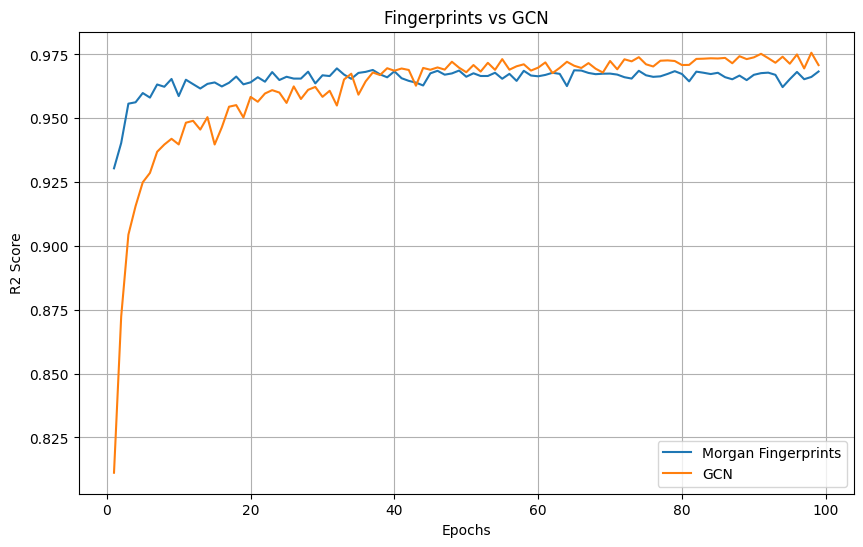

In [43]:
epochs_list = [i for i in range(1, EPOCHS)]
plt.figure(figsize=(10, 6))
plt.plot(epochs_list, r2_score_value_fp, label='Morgan Fingerprints')
plt.plot(epochs_list, r2_score_value_gcn, label='GCN')
plt.xlabel('Epochs')
plt.ylabel('R2 Score')
plt.title('Fingerprints vs GCN')
plt.legend()
plt.grid(True)
plt.show()